# Custom Neural Network

This is an evaluation of the custom fully dense neural network model I made from scratch in this project.

We will be testing how my model performs on two popular datasets:

- California Housing DataSet (https://www.kaggle.com/datasets/camnugent/california-housing-prices)
- MNIST Digit Recognization DataSet (https://www.kaggle.com/competitions/digit-recognizer/data)

My custom model was developed using the NumPy library and my own mathematical knowledge.

## California Housing Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preparation

In [2]:
housing_data = pd.read_csv('Datasets\CaliforniaHousing.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


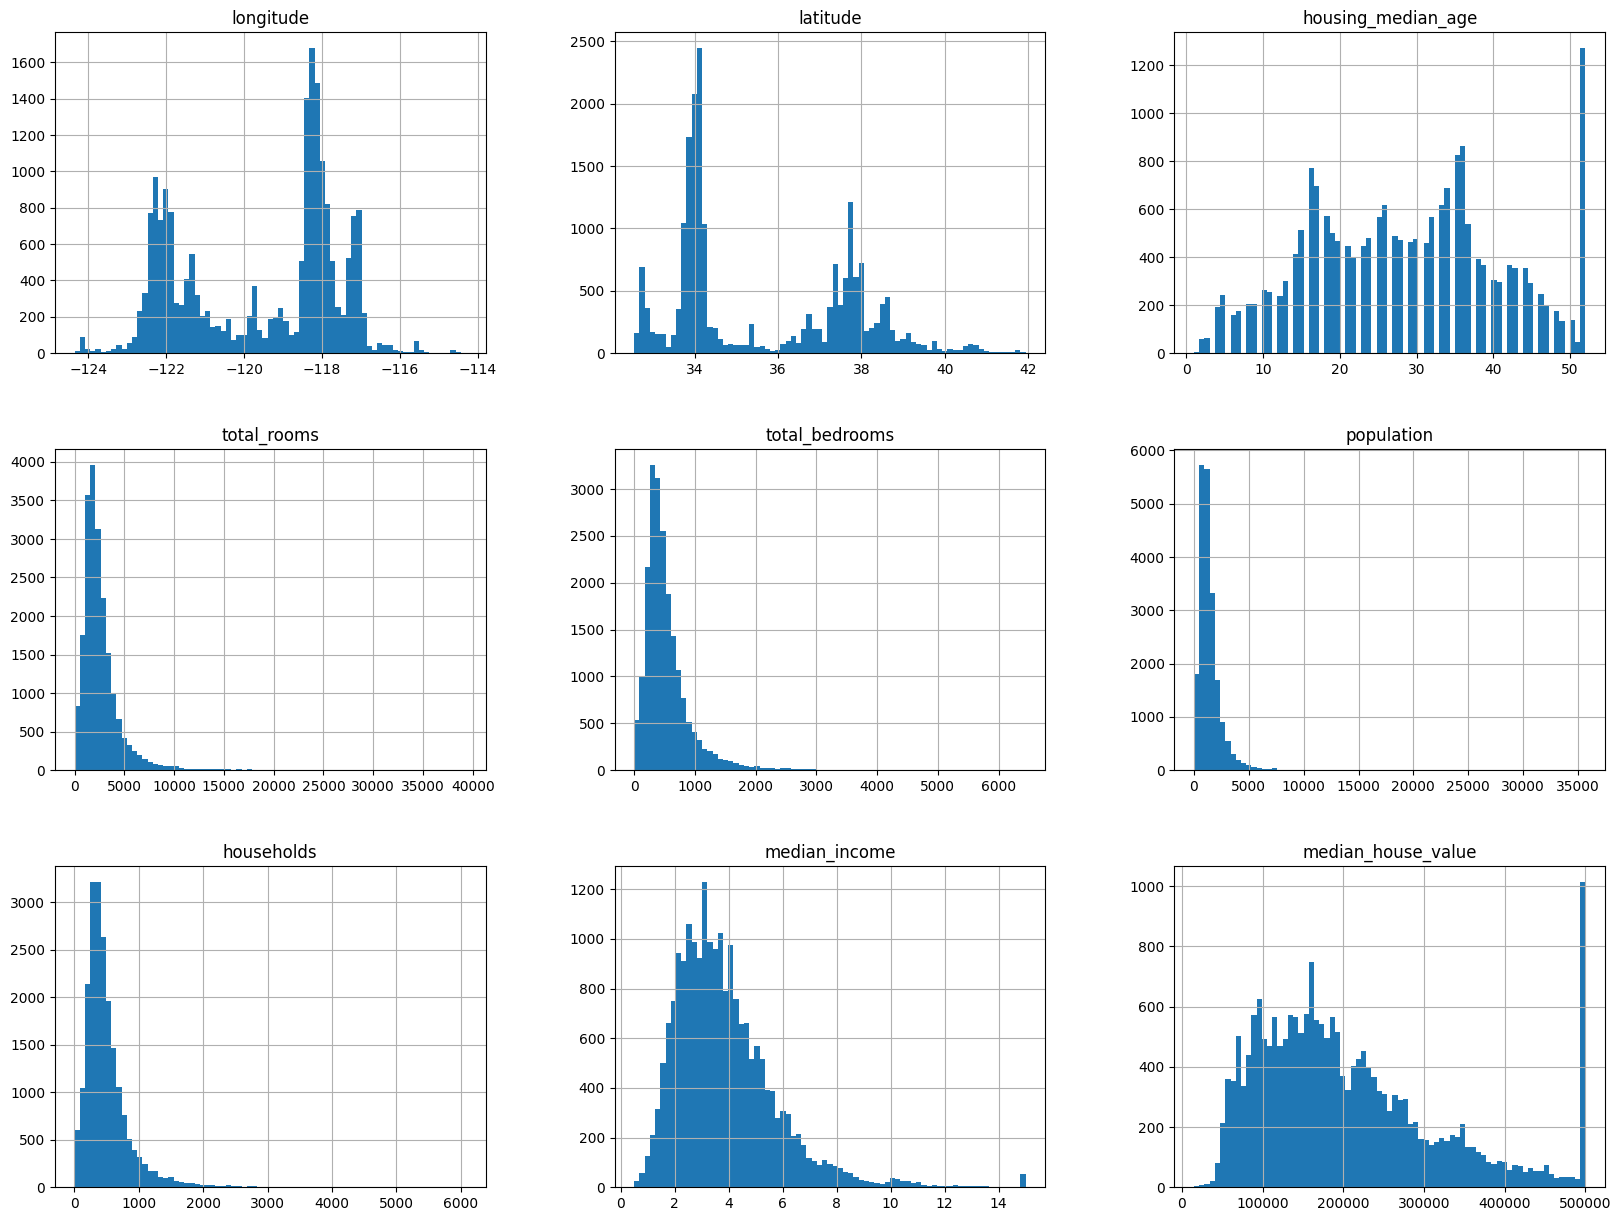

In [3]:
housing_data.hist(bins=75, figsize=(20,15))
plt.show()

### Cleaning the DataSet

First, we scramble the dataset so there will be no permuation bias.

In [4]:
housing_data = housing_data.sample(frac=1, random_state=12)
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6906,-118.13,34.04,42.0,2205.0,451.0,1392.0,423.0,4.3646,211400.0,<1H OCEAN
767,-122.09,37.65,27.0,2630.0,722.0,1414.0,634.0,2.8203,195200.0,NEAR BAY
10555,-117.71,33.63,16.0,2497.0,500.0,1357.0,456.0,4.5909,241800.0,<1H OCEAN
17456,-120.43,34.69,33.0,2054.0,373.0,1067.0,358.0,3.6023,128300.0,NEAR OCEAN
20617,-121.53,39.06,20.0,561.0,109.0,308.0,114.0,3.3021,70800.0,INLAND


For this project, we will drop the data points with Nan values.

In [5]:
housing_data = housing_data.dropna()

Next, we will convert the text and categorical values into quantitative ones.

In [6]:
housing_data[["ocean_proximity"]].value_counts()

ocean_proximity
<1H OCEAN          9034
INLAND             6496
NEAR OCEAN         2628
NEAR BAY           2270
ISLAND                5
dtype: int64

In [7]:
ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}
housing_data['ocean_proximity'] = housing_data['ocean_proximity'].map(ocean_proximity_mapping)
housing_data['ocean_proximity'].head()

6906     0
767      3
10555    0
17456    2
20617    1
Name: ocean_proximity, dtype: int64

### Creating Training and Test Sets

Now that we have cleaned our data, we can create the test and training sets:

(split_train_test function was borrowed from the O'Reily ML Textbook by Geron Aurelien)

In [8]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

We will use a training-test set ratio of 30:70.

In [9]:
train_set, test_set = split_train_test(housing_data, 0.3)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6177,-117.91,34.08,33.0,2325.0,452.0,1170.0,445.0,3.6625,217100.0,0
3238,-119.56,36.10,25.0,1093.0,262.0,893.0,252.0,2.1300,50800.0,1
7327,-118.17,33.97,31.0,3388.0,1059.0,3558.0,957.0,2.4049,159000.0,0
13153,-121.60,36.88,21.0,3416.0,624.0,1862.0,595.0,4.7813,241500.0,0
5560,-118.44,33.95,37.0,2076.0,332.0,771.0,327.0,6.2551,500001.0,0


### Feature Scaling

In order for a neural network to perform the best, we must scale the training data down to the same scale. We will use the Sci-kit Learn Z-score normalization scaler for this.

In [10]:
from sklearn.preprocessing import StandardScaler

z_score_scaler = StandardScaler()

fitted_train_set = z_score_scaler.fit_transform(train_set)
train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
train_y = train_set["median_house_value"].values

scaled_test_set = z_score_scaler.transform(test_set)
test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
test_y = test_set["median_house_value"].values

# # scale y
# y_scaler = StandardScaler()
# train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
# test_y = y_scaler.transform(test_y.reshape(-1, 1))

train_y[:3]

array([217100.,  50800., 159000.])

Combining the shuffling and scaling into a single function:

In [11]:
def shuffle_scale(data, ratio):
    train_set, test_set = split_train_test(data, ratio)
    z_score_scaler = StandardScaler()

    fitted_train_set = z_score_scaler.fit_transform(train_set)
    train_X = pd.DataFrame(fitted_train_set, columns=train_set.columns).drop("median_house_value", axis=1).values
    train_y = train_set["median_house_value"].values

    scaled_test_set = z_score_scaler.transform(test_set)
    test_X = pd.DataFrame(scaled_test_set, columns=test_set.columns).drop("median_house_value", axis=1).values
    test_y = test_set["median_house_value"].values
    
    return train_X, train_y, test_X, test_y

Now that we have our training and test sets, we can being training our model.

### Training Model

For our model, we will use a 4 layer deep fully connected neural network with a ReLu activation function for each hidden layer.

Creating a model using my custom package is similar to Tensorflow's method.

In [2]:
from Model import *
import tensorflow as tf

my_model = Model(Layers=[
    Dense_Layer(input_shape=9,output_shape=30, activation_func="lrelu"),
    Dense_Layer(input_shape=30,output_shape=6, activation_func="lrelu"),
    Output_Layer(input_shape=6,output_shape=1)
])
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_shape=(9,), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(6, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dense(1)  # Output layer, no activation for regression
])

# Compile the model with SGD optimizer
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                300       
                                                                 
 dense_1 (Dense)             (None, 6)                 186       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


In [56]:
# long_test_err = []
# long_train_err = []

# tf_err = []

train_X, train_y, test_X, test_y = shuffle_scale(housing_data, 0.3)
train_err = my_model.fit(train_X, train_y, epochs=25, learning_rate=0.000000002)
# tf_err.append(model.fit(train_X, train_y, epochs=5, batch_size=32, verbose=0))
test_err = []
for i in range(len(test_X)):
    pred = my_model.forward_pass(test_X[i])
    test_err.append(abs(pred - test_y[i]))
long_test_err += test_err
long_train_err += train_err

plt.scatter(range(len(long_test_err)), long_test_err, s=1)
plt.xlabel("Iterations")
plt.ylabel("Absolute Error")
plt.title(f"{len(my_model.get_Layers())}-Layer Deep Neural Network Error")
plt.show()

Epoch 1/25, Average MSE: 3934840498.6740837
Epoch 2/25, Average MSE: 3927720118.2092195
Epoch 3/25, Average MSE: 3905159205.300248
Epoch 4/25, Average MSE: 3938335771.963243
Epoch 5/25, Average MSE: 3933630456.281931
Epoch 6/25, Average MSE: 3915619046.907809
Epoch 7/25, Average MSE: 3959276294.0608625
Epoch 8/25, Average MSE: 3961190958.5582128
Epoch 9/25, Average MSE: 4019575885.5097528
Epoch 10/25, Average MSE: 4106357209.483209
Epoch 11/25, Average MSE: 3995591567.165133
Epoch 12/25, Average MSE: 3860460912.399862
Epoch 13/25, Average MSE: 3843742280.9331284
Epoch 14/25, Average MSE: 3845231281.2658496
Epoch 15/25, Average MSE: 3791937799.23522
Epoch 16/25, Average MSE: 3756758443.437148
Epoch 17/25, Average MSE: 4202483892.345534
Epoch 18/25, Average MSE: 3952922478.0107923


c:\Users\Jason_yj4bjfp\VSProjects\NeuralNetwork\Model.py:84: RuntimeWarning: overflow encountered in square
  sample_mse = np.mean(error_output_layer ** 2)
c:\Users\Jason_yj4bjfp\VSProjects\NeuralNetwork\Model.py:98: RuntimeWarning: overflow encountered in double_scalars
  error = sum([deltas[0][k] * next_layer.get_neurons()[k].get_weights()[i]
c:\Users\Jason_yj4bjfp\VSProjects\NeuralNetwork\Model.py:98: RuntimeWarning: invalid value encountered in double_scalars
  error = sum([deltas[0][k] * next_layer.get_neurons()[k].get_weights()[i]
c:\Users\Jason_yj4bjfp\VSProjects\NeuralNetwork\Model.py:112: RuntimeWarning: overflow encountered in multiply
  adj_weights = weights[:-1] - learning_rate * delta_i * input_activation


Epoch 19/25, Average MSE: nan


KeyboardInterrupt: 

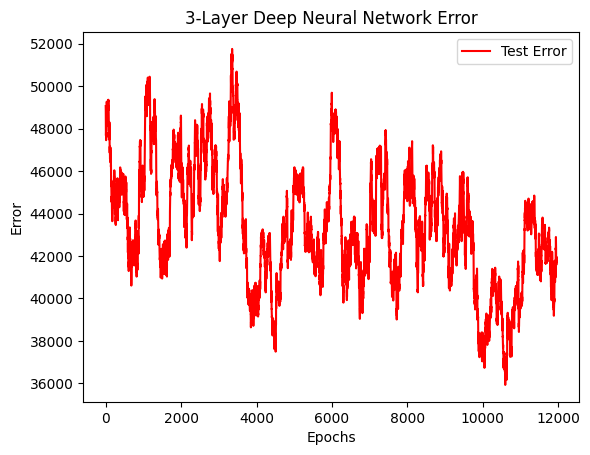

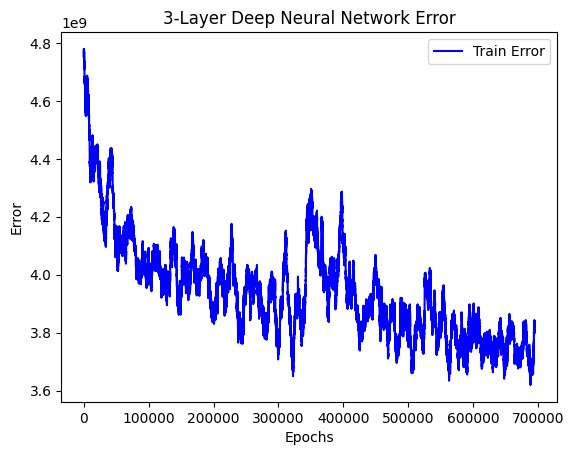

In [57]:
mv_train_err = np.convolve(long_train_err, np.ones(10000)/10000, mode='valid')


mv_test_err = np.convolve([x[0] for x in long_test_err], np.ones(300)/300, mode='valid')

plt.plot(mv_test_err, label="Test Error", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()
plt.plot(mv_train_err[10000:], label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(my_model.get_Layers())))
plt.show()

(0.0, 500000.0)

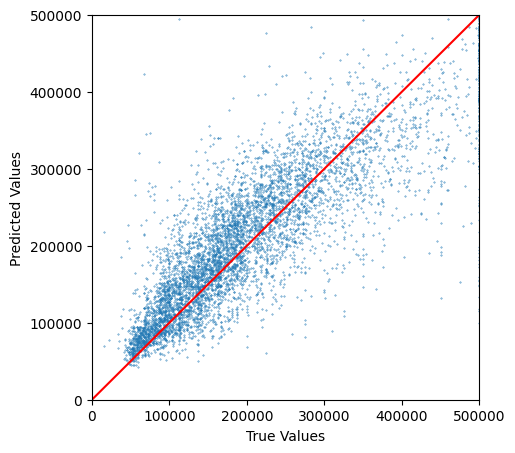

In [53]:
plt.figure(figsize=(7, 7))
plt.scatter(test_y[:6129], [my_model.forward_pass(test_X[d]) for d in range(6129)], s=0.11)
plt.plot([0, 500000], [0, 500000], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
# make the axes the same range
plt.xlim(0, 500000)
plt.ylim(0, 500000)

## MNIST Digit Recognizer DataSet

Moving onto the MNIST Digit Recongizer DataSet, we will be classifying handwritten numbers into their corresponding digits.

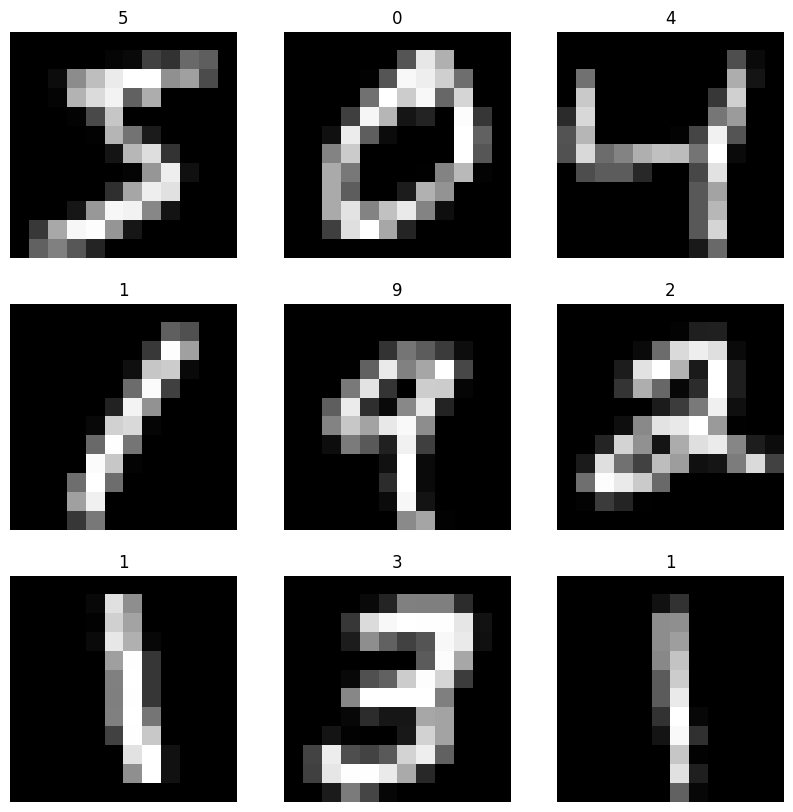

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = tf.image.resize(X_train[..., tf.newaxis], [14, 14]).numpy()
X_test = tf.image.resize(X_test[..., tf.newaxis], [14, 14]).numpy()

X_train = X_train[:, 1:-1, 1:-1]
X_test = X_test[:, 1:-1, 1:-1]

X_train = X_train.reshape((X_train.shape[0], 12 * 12)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 12 * 12)).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(12, 12), cmap='gray')
    plt.title(np.argmax(y_train[i]))
    plt.axis('off')
plt.show()

In [2]:
from Model import *

model = Model(Layers=[
    Dense_Layer(input_shape=144, output_shape=32, activation_func="relu"),
    Dense_Layer(input_shape=32, output_shape=20, activation_func="relu"),
    Output_Layer(input_shape=20, output_shape=10, activation_func="softmax")
])

model.summary()

Dense Layer  | 32 neurons | 144 weights | 1 bias
Dense Layer  | 20 neurons | 32 weights | 1 bias
Output Layer | 10 outputs | 20 weights | 1 bias
Input Shape: 144
Output Shape: 10


Epoch 1/1, Average Loss: 0.014200071830120894


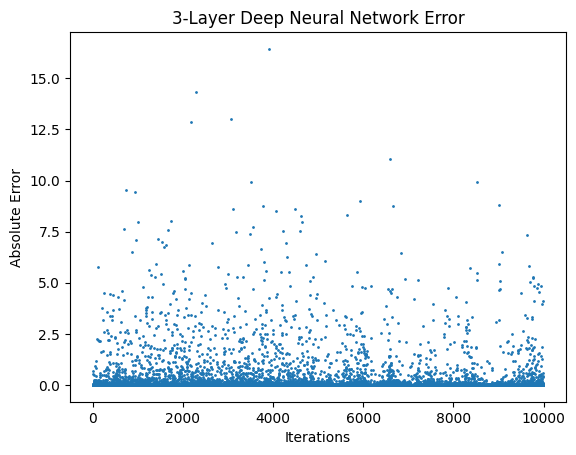

In [3]:
long_test_err = []
long_train_err = []

train_err, best_model = model.fit(X_train, y_train, epochs=1, learning_rate=0.01)
test_err = []
for i in range(len(X_test)):
    pred = best_model.forward_pass(X_test[i])
    # cross entropy loss
    test_err.append(-np.log(pred[np.argmax(y_test[i])]))
long_test_err += test_err
long_train_err += train_err

plt.scatter(range(len(long_test_err)), long_test_err, s=1)
plt.xlabel("Iterations")
plt.ylabel("Absolute Error")
plt.title(f"{len(model.get_Layers())}-Layer Deep Neural Network Error")
plt.show()

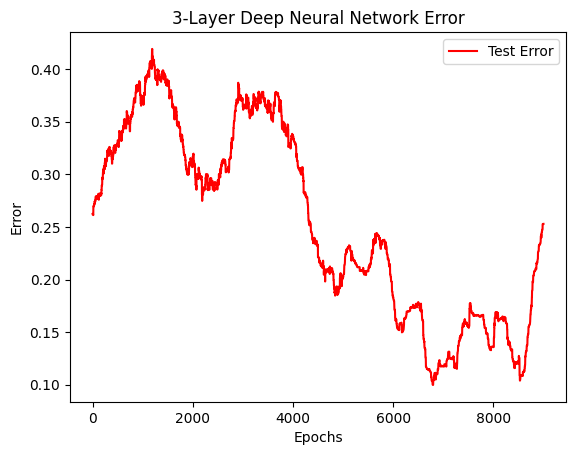

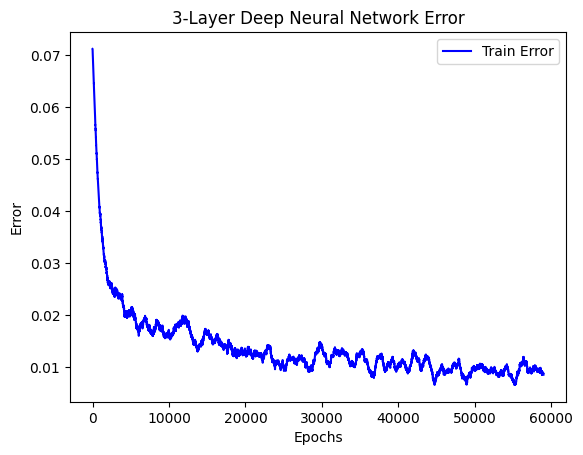

In [5]:
mv_train_err = np.convolve(long_train_err, np.ones(1000)/1000, mode='valid')

mv_test_err = np.convolve(long_test_err, np.ones(1000)/1000, mode='valid')

plt.plot(mv_test_err, label="Test Error", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()
plt.plot(mv_train_err, label="Train Error", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

Accuracy: 0.9445
Recall: 0.112
Best Accuracy: 0.9208
Best Recall: 0.1099


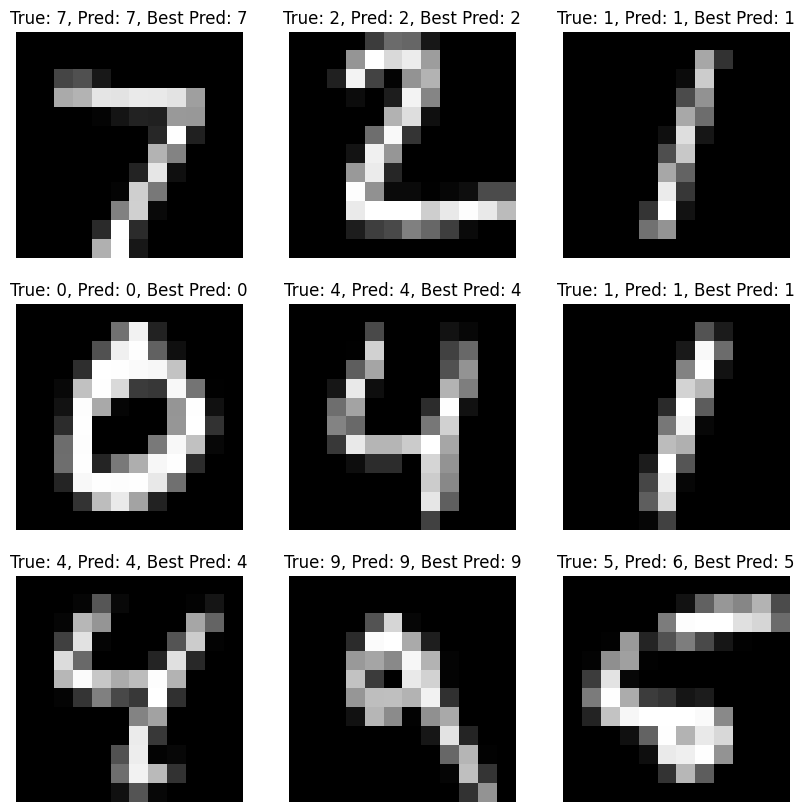

In [6]:
predictions = [model.forward_pass(X_test[i]) for i in range(len(X_test))]
best_predictions = [best_model.forward_pass(X_test[i]) for i in range(len(X_test))]

accuracy = np.mean([np.argmax(predictions[i]) == np.argmax(y_test[i]) for i in range(len(predictions))])
print(f"Accuracy: {accuracy}")
recall = np.mean([np.argmax(predictions[i]) == np.argmax(y_test[i]) and np.argmax(y_test[i]) == 1 for i in range(len(predictions))])
print(f"Recall: {recall}")

best_accuracy = np.mean([np.argmax(best_predictions[i]) == np.argmax(y_test[i]) for i in range(len(best_predictions))])
print(f"Best Accuracy: {best_accuracy}")
best_recall = np.mean([np.argmax(best_predictions[i]) == np.argmax(y_test[i]) and np.argmax(y_test[i]) == 1 for i in range(len(best_predictions))])
print(f"Best Recall: {best_recall}")

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(12, 12), cmap='gray')
    plt.title(f"True: {np.argmax(y_test[i])}, Pred: {np.argmax(predictions[i])}, Best Pred: {np.argmax(best_predictions[i])}")
    plt.axis('off')
plt.show()

In [31]:
model.forward_pass(X_test[0])

array([4.88160676e-07, 2.44506837e-07, 2.52457142e-04, 2.44159629e-04,
       1.82616106e-07, 4.57601701e-07, 9.16663682e-11, 9.99325240e-01,
       1.38950039e-05, 1.62875122e-04])